## Imports

In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import mayavi
import DataAndCodeAssignment3.ps_utils as ps

YOU HAVE TO USE PYTHON 3.12 FOR THIS TO WORK

## Woodmans approach for photometric stereo, based on assignment description

In [3]:
def woodham_ps_matrix(I , Mask, S):

    m, n , k = I.shape # m rows, n collumns, k images (lights)

    valid_pixels = np.where(Mask == 1) # find the valid pixels in the mask
    nz = len(valid_pixels[0]) # number of valid pixels

    J = np.zeros((k , nz)) # initialize the intensity matrix
    for i in range(k):
        J[i,:] = I[:,:,i][valid_pixels] # fill the intensity matrix

    S_inv = np.linalg.pinv(S) # find the inverse of S
    M = S_inv @ J  # solve for M = S_inv @ J

    albedo = np.linalg.norm(M , axis = 0) # find the albedo ||g||

    normals = M / albedo # find the normals n = g / ||g||

    ## NOW put it back into image form
    # create empty images
    albedo_image = np.zeros((m , n))  # albedo is a single channel image
    normals_image = np.zeros((m, n, 3))
    normals_image[:,:,2] = 1   # safe background normal


    
    
    # 3  because the surface normal has 3 components

    # FILL it up man
    albedo_image[valid_pixels] = albedo
    normals_image[valid_pixels] = normals.T # transpose to match the shape, didnt work without it...
    
    return normals_image , albedo_image

## Woodmans photometric stereo with Ransac

In [4]:
def woodham_ransac(I , Mask, S, threshold =2.0):

    m , n , k = I.shape # m rows, n collumns, k images (lights)
    albedo = np.zeros((m , n)) # initialize albedo
    N = np.zeros((m , n , 3)) # initialize normals
    N[:,:,2] = 1 

    for u in range(m):
        for v in range(n):
            if Mask[u , v] == 1: # only use pixels in the mask

                I_vec = I[u , v , :] # Make the intensity vector
                
                #RANSAC ###############################
                g, best_inliers , best_fit= ps.ransac_3dvector((I_vec, S), threshold, verbose = 0)

                rho = np.linalg.norm(g) # find the albedo
                albedo[u , v] = rho

                if rho> 0:
                    N[u, v, :] = g /rho

    return N, albedo

### Helper Function

In [5]:
def extract_surface_normals(normals_image):
    # Extract normal components
    n1 = normals_image[:,:,0]
    n2 = normals_image[:,:,1]
    n3 = normals_image[:,:,2]
    return n1, n2, n3


# Beethoven dataset

In [6]:
# Load data
I, Mask, S = ps.read_data_file('DataAndCodeAssignment3/beethoven.mat')

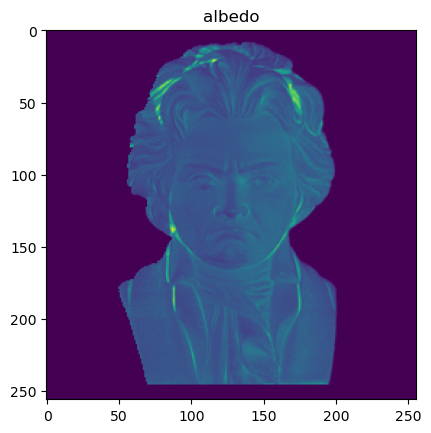

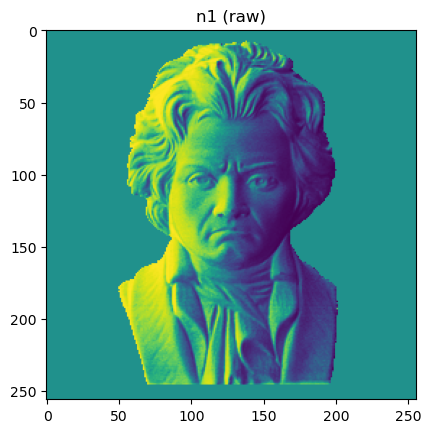

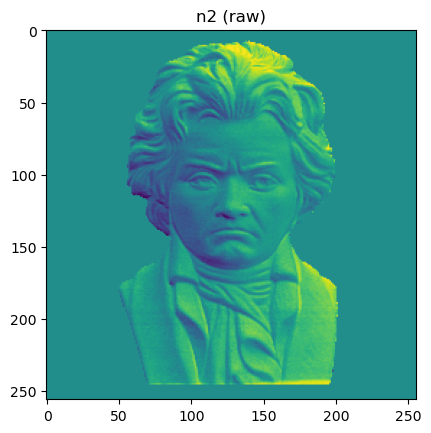

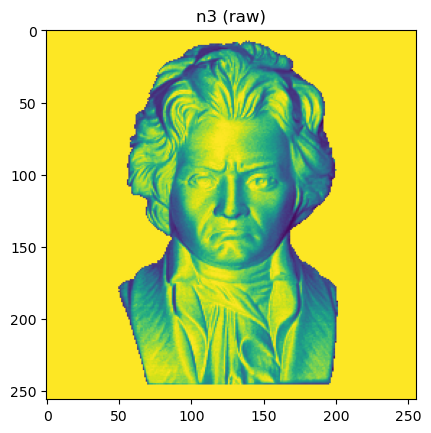

In [7]:
normals_image, albedo_image = woodham_ps_matrix(I , Mask, S)
n1, n2, n3 = extract_surface_normals(normals_image)

# Visualize albedo image
plt.imshow(albedo_image); plt.title("albedo"); plt.show()

# --- Raw normals ---
plt.imshow(n1); plt.title("n1 (raw)"); plt.show()
plt.imshow(n2); plt.title("n2 (raw)"); plt.show()
plt.imshow(n3); plt.title("n3 (raw)"); plt.show()


## depth map

In [8]:
#depth map reconstruction
z = ps.unbiased_integrate(n1, n2, n3, Mask)
z = np.nan_to_num(z)
ps.display_surface(z)

# Beethoven Mikkel

# -*- coding: utf-8 -*-
"""
Run Beethoven reconstruction code 

Author: Francois Lauze, University of Copenhagen
Date: Mon Jan  4 14:11:54 2016
"""


import numpy as np
import DataAndCodeAssignment3.ps_utils as ps
import numpy.linalg as la
import matplotlib.pyplot as plt

# read Beethoven data
I, mask, S = ps.read_data_file('DataAndCodeAssignment3/beethoven.mat')

# get indices of non zero pixels in mask
nz = np.where(mask > 0)
m,n = mask.shape

# for each mask pixel, collect image data
J = np.zeros((3, len(nz[0])))
for i in range(3):
    Ii = I[:,:,i]
    J[i,:] = Ii[nz]


# solve for M = rho*N
iS = la.inv(S)
M = np.dot(iS, J)

# get albedo as norm of M and normalize M
Rho = la.norm(M, axis=0)
N = M/np.tile(Rho, (3,1))

# show albedo inside mask
rho_img = np.zeros((m, n))
rho_img[nz] = Rho
plt.figure()
plt.imshow(rho_img)
plt.title("Albedo")
plt.colorbar()

# normal components in image form
n1 = np.zeros((m,n))
n2 = np.zeros((m,n))
n3 = np.ones((m,n))
n1[nz] = N[0,:]
n2[nz] = N[1,:]
n3[nz] = N[2,:]

_,(ax1,ax2,ax3) = plt.subplots(1,3)
ax1.imshow(n1)
ax1.set_title("n1")
ax2.imshow(n2)
ax2.set_title("n2")
ax3.imshow(n3)
ax3.set_title("n3")
plt.show()

z = ps.unbiased_integrate(n1, n2, n3, mask)
z = np.nan_to_num(z)

ps.display_surface(z)

## Mat_vase Dataset

In [8]:
# Load data
I, Mask, S = ps.read_data_file('DataAndCodeAssignment3/mat_vase.mat')

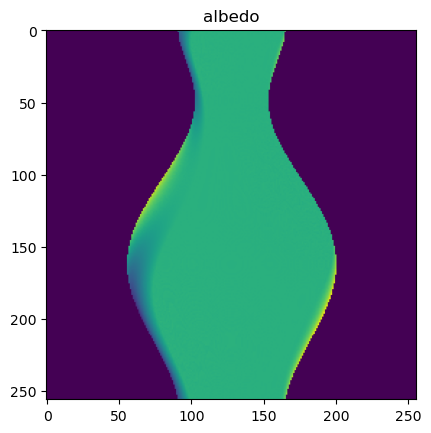

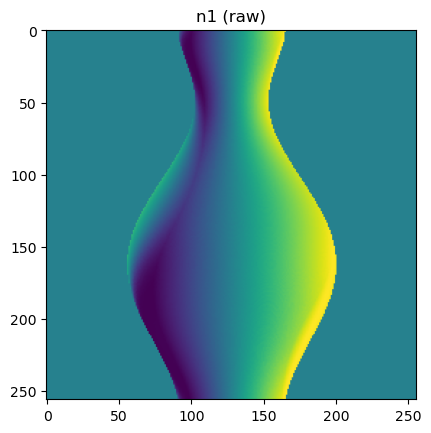

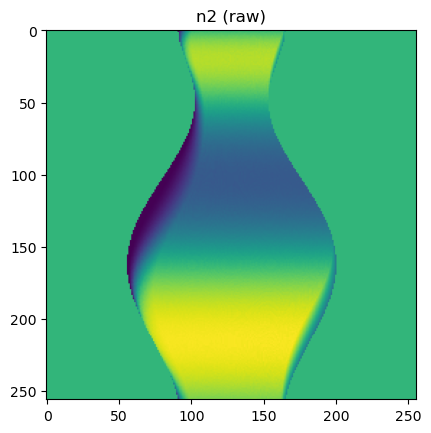

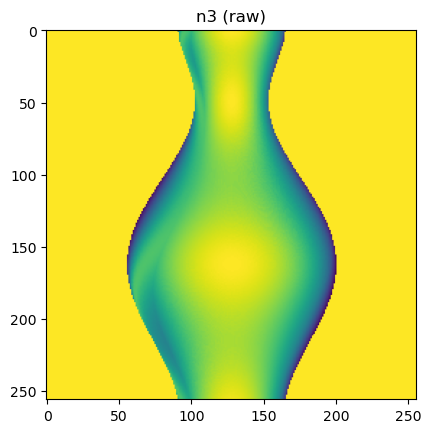

In [9]:
normals_image, albedo_image = woodham_ps_matrix(I , Mask, S)
n1, n2, n3 = extract_surface_normals(normals_image)

# Visualize albedo image
plt.imshow(albedo_image); plt.title("albedo"); plt.show()

# --- Raw normals ---
plt.imshow(n1); plt.title("n1 (raw)"); plt.show()
plt.imshow(n2); plt.title("n2 (raw)"); plt.show()
plt.imshow(n3); plt.title("n3 (raw)"); plt.show()


## depth map

In [10]:
#depth map reconstruction
z = ps.unbiased_integrate(n1, n2, n3, Mask)
z = np.nan_to_num(z)
ps.display_surface(z)

## Shiny_vase Dataset

In [8]:
# Load data
I, Mask, S = ps.read_data_file('DataAndCodeAssignment3/shiny_vase.mat')

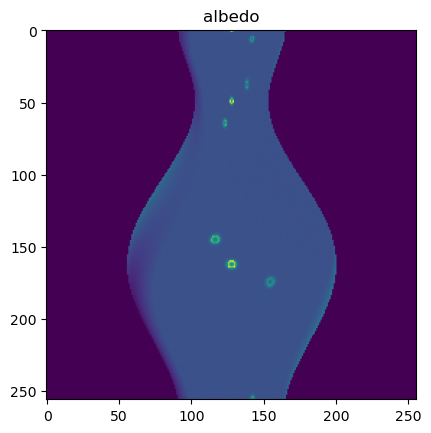

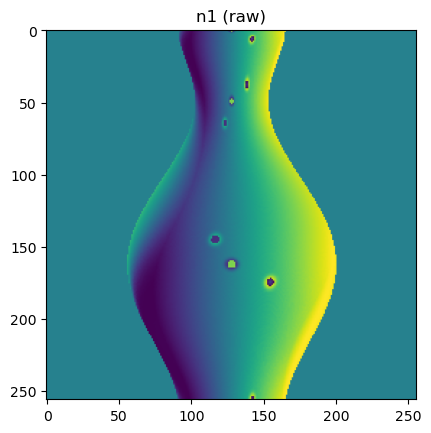

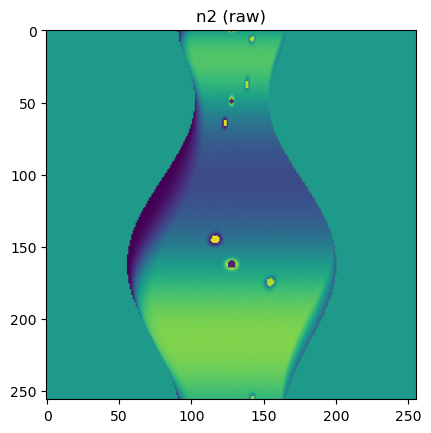

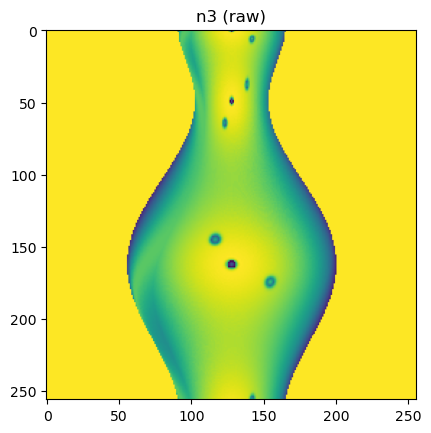

In [9]:
normals_image, albedo_image = woodham_ps_matrix(I , Mask, S)
n1, n2, n3 = extract_surface_normals(normals_image)

# Visualize albedo image
plt.imshow(albedo_image); plt.title("albedo"); plt.show()

# --- Raw normals ---
plt.imshow(n1); plt.title("n1 (raw)"); plt.show()
plt.imshow(n2); plt.title("n2 (raw)"); plt.show()
plt.imshow(n3); plt.title("n3 (raw)"); plt.show()



## Depth map

In [13]:
#depth map reconstruction
z = ps.unbiased_integrate(n1, n2, n3, Mask)
z = np.nan_to_num(z)
ps.display_surface(z)

## Ransac version 

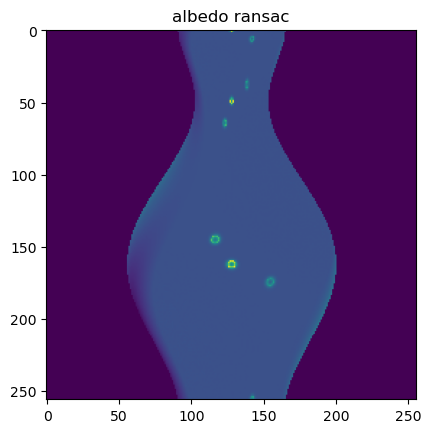

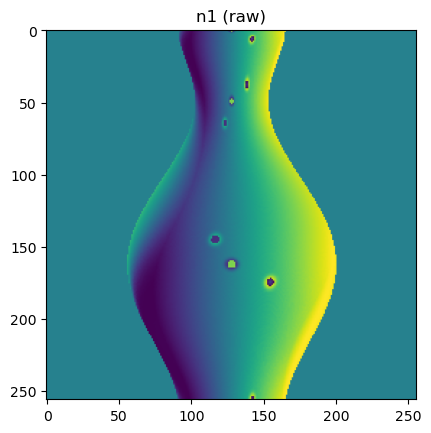

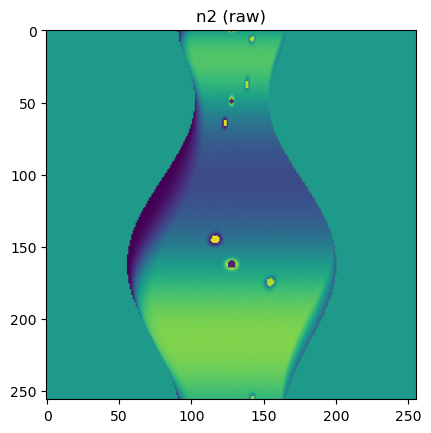

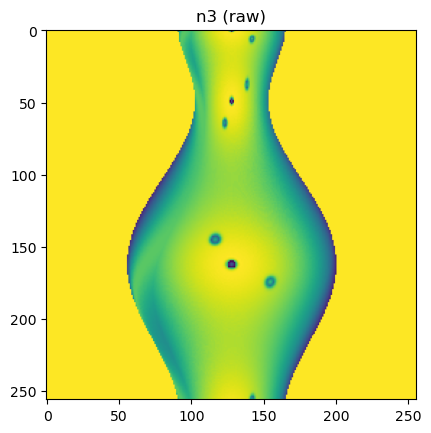

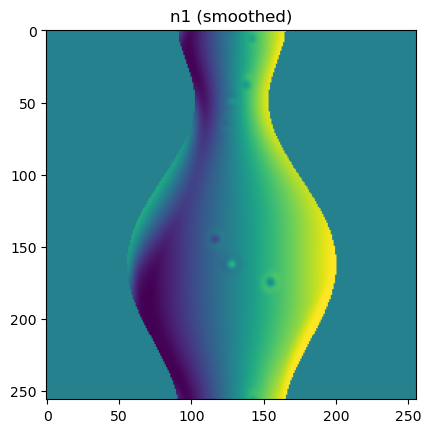

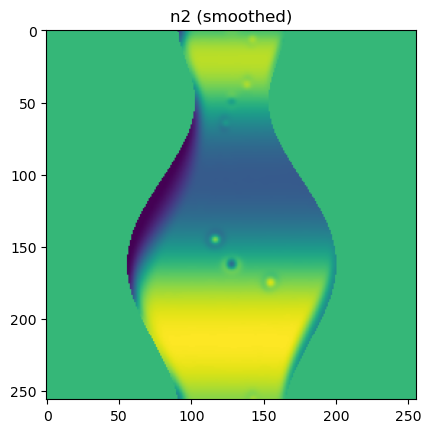

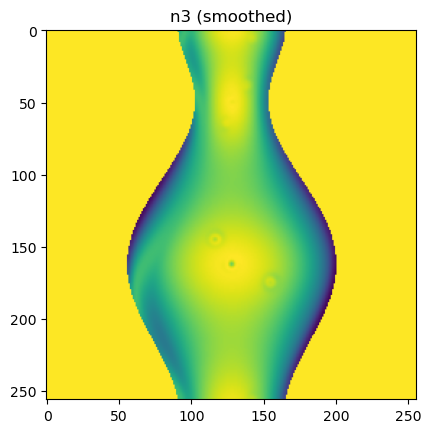

In [13]:

############################## RANSAC version ##############################
normals_image, albedo_image = woodham_ransac(I , Mask, S, threshold=2.0)
n1r, n2r, n3r = extract_surface_normals(normals_image)

# Visualize albedo image
plt.imshow(albedo_image); plt.title("albedo ransac"); plt.show()

#### Raw normals 
plt.imshow(n1r); plt.title("n1 (raw)"); plt.show()
plt.imshow(n2r); plt.title("n2 (raw)"); plt.show()
plt.imshow(n3r); plt.title("n3 (raw)"); plt.show()

# Smooth the normal field
n1rs, n2rs, n3rs = ps.smooth_normal_field(n1r, n2r, n3r, mask= Mask, iters=50) #change iteration number here

###smoothed normals
plt.imshow(n1rs); plt.title("n1 (smoothed)"); plt.show()
plt.imshow(n2rs); plt.title("n2 (smoothed)"); plt.show()
plt.imshow(n3rs); plt.title("n3 (smoothed)"); plt.show()

## Shiny vase 2 dataset

In [15]:
# Load data
I, Mask, S = ps.read_data_file('DataAndCodeAssignment3/shiny_vase2.mat')

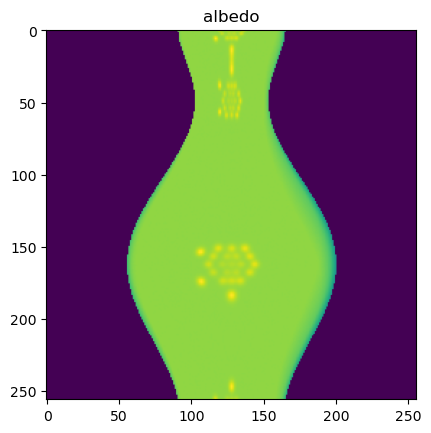

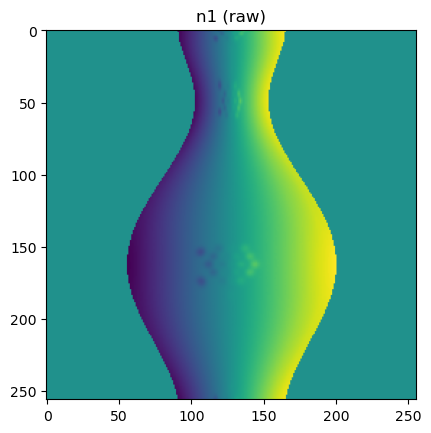

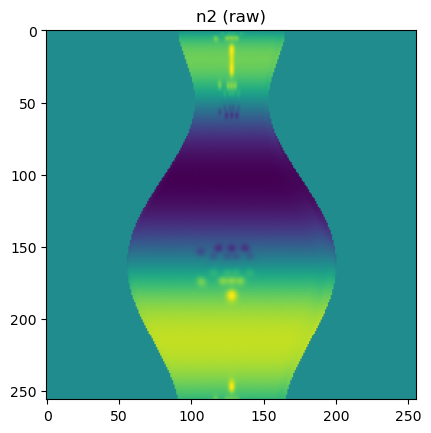

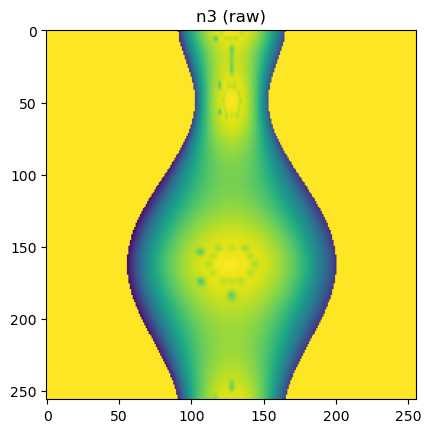

In [16]:
normals_image, albedo_image = woodham_ps_matrix(I , Mask, S)
n1, n2, n3 = extract_surface_normals(normals_image)

# Visualize albedo image
plt.imshow(albedo_image); plt.title("albedo"); plt.show()

# --- Raw normals ---
plt.imshow(n1); plt.title("n1 (raw)"); plt.show()
plt.imshow(n2); plt.title("n2 (raw)"); plt.show()
plt.imshow(n3); plt.title("n3 (raw)"); plt.show()



## Depth map

In [17]:
#depth map reconstruction
z = ps.unbiased_integrate(n1, n2, n3, Mask)
z = np.nan_to_num(z)
ps.display_surface(z)

## RANSAC

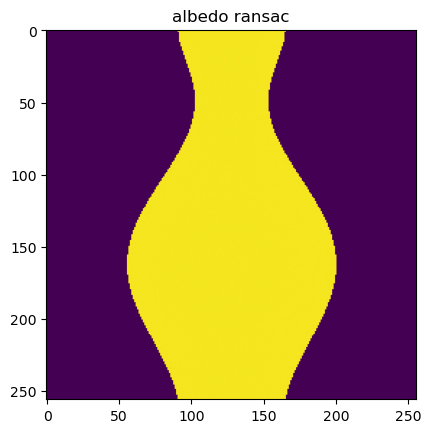

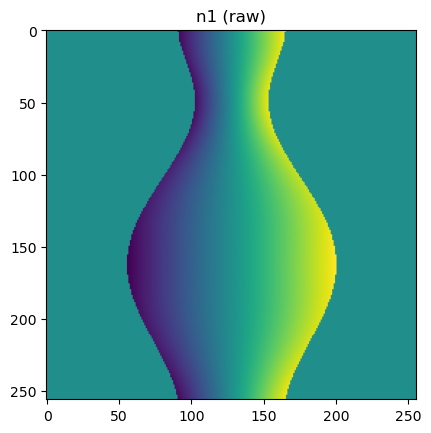

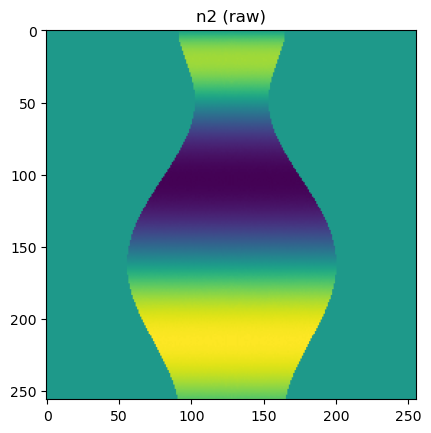

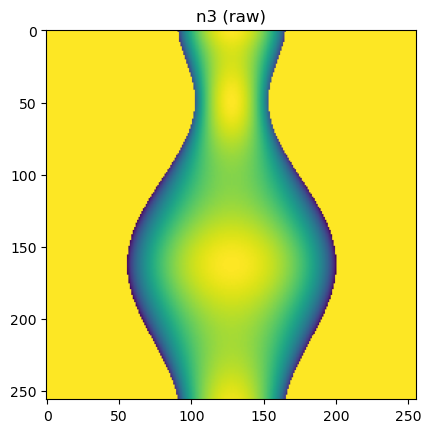

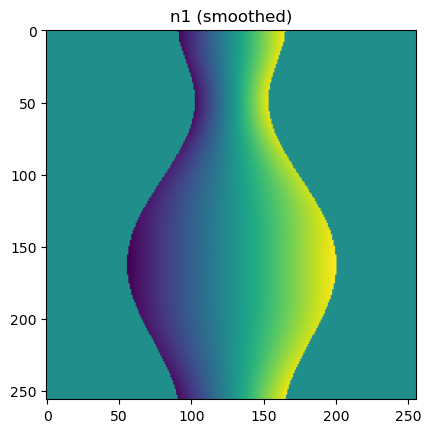

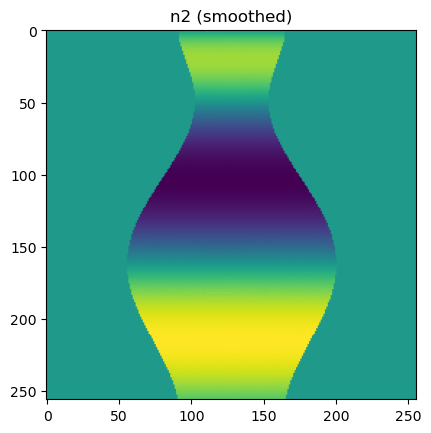

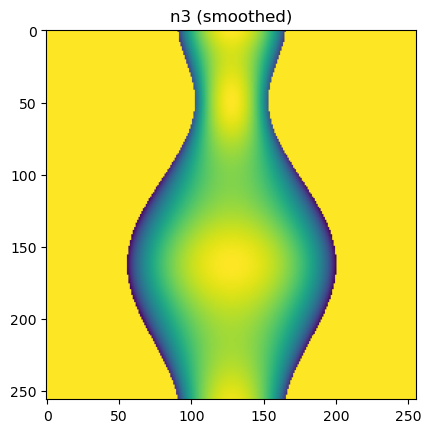

In [18]:

############################## RANSAC version ##############################
normals_image, albedo_image = woodham_ransac(I , Mask, S, threshold=2.0)
n1r, n2r, n3r = extract_surface_normals(normals_image)

# Visualize albedo image
plt.imshow(albedo_image); plt.title("albedo ransac"); plt.show()

#### Raw normals 
plt.imshow(n1r); plt.title("n1 (raw)"); plt.show()
plt.imshow(n2r); plt.title("n2 (raw)"); plt.show()
plt.imshow(n3r); plt.title("n3 (raw)"); plt.show()

# Smooth the normal field
n1rs, n2rs, n3rs = ps.smooth_normal_field(n1r, n2r, n3r, mask= Mask, iters=8) #change iteration number here

###smoothed normals
plt.imshow(n1rs); plt.title("n1 (smoothed)"); plt.show()
plt.imshow(n2rs); plt.title("n2 (smoothed)"); plt.show()
plt.imshow(n3rs); plt.title("n3 (smoothed)"); plt.show()

## Buddha Dataset

In [9]:
# Load data
I, Mask, S = ps.read_data_file('DataAndCodeAssignment3/buddha.mat')

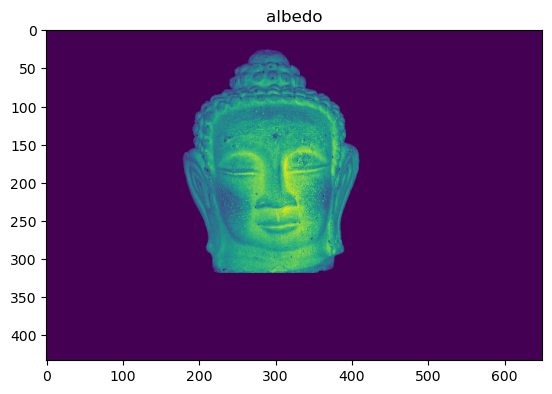

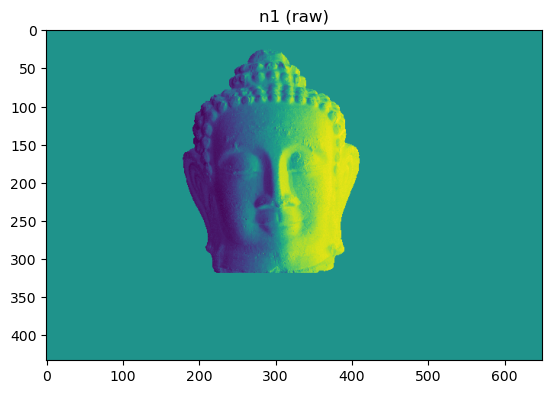

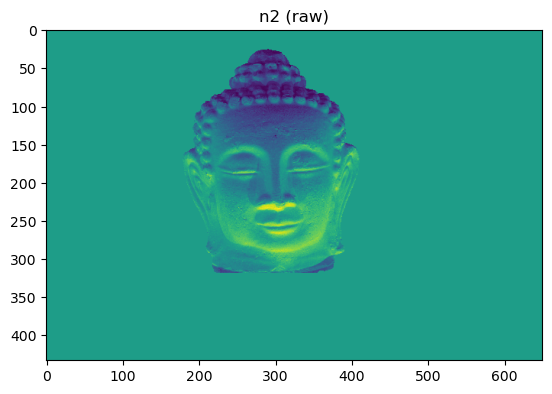

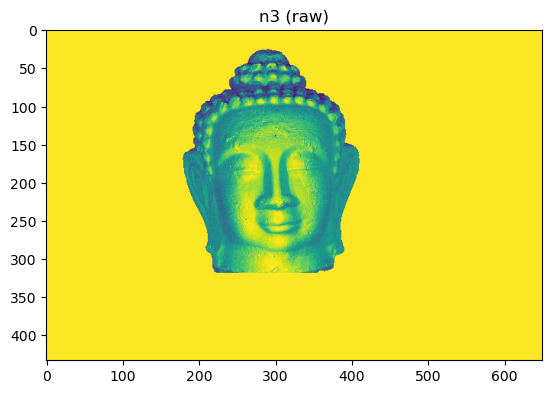

In [10]:
normals_image, albedo_image = woodham_ps_matrix(I , Mask, S)
n1, n2, n3 = extract_surface_normals(normals_image)

# Visualize albedo image
plt.imshow(albedo_image); plt.title("albedo"); plt.show()

# --- Raw normals ---
plt.imshow(n1); plt.title("n1 (raw)"); plt.show()
plt.imshow(n2); plt.title("n2 (raw)"); plt.show()
plt.imshow(n3); plt.title("n3 (raw)"); plt.show()
#depth map reconstruction
#z = ps.unbiased_integrate(n1, n2, n3, Mask)
#z = np.nan_to_num(z)
#ps.display_surface(z)


## Depth map

In [11]:
#depth map reconstruction
z = ps.unbiased_integrate(n1, n2, n3, Mask)
z = np.nan_to_num(z)
ps.display_surface(z)

## RANSAC

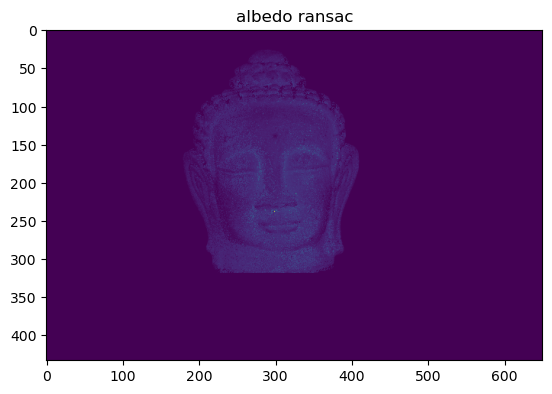

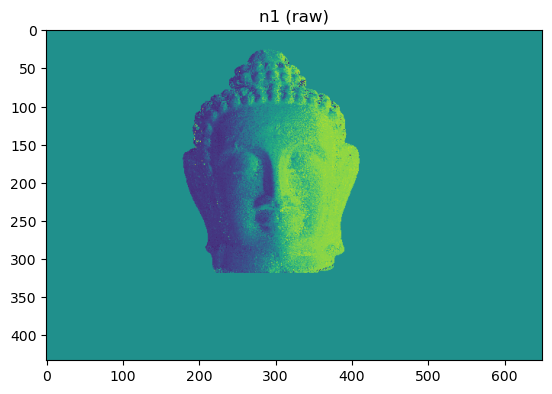

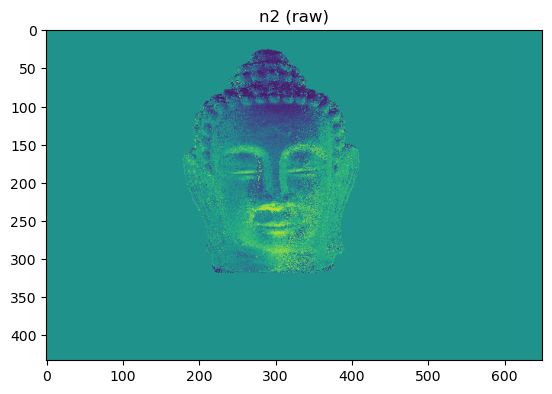

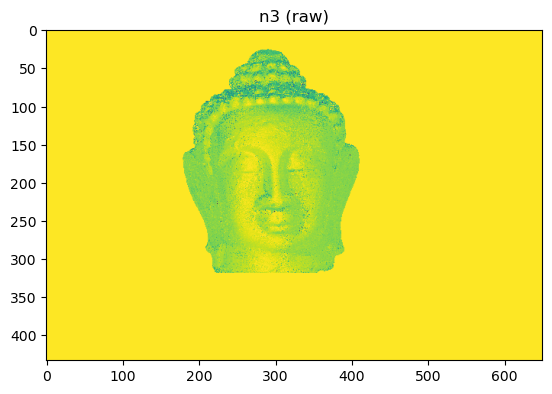

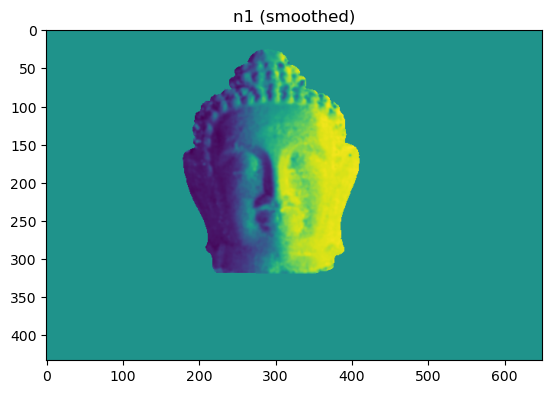

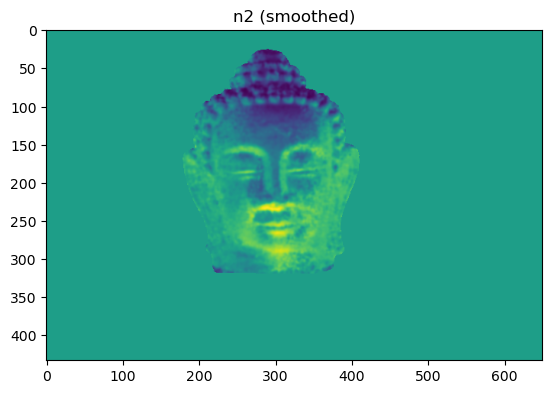

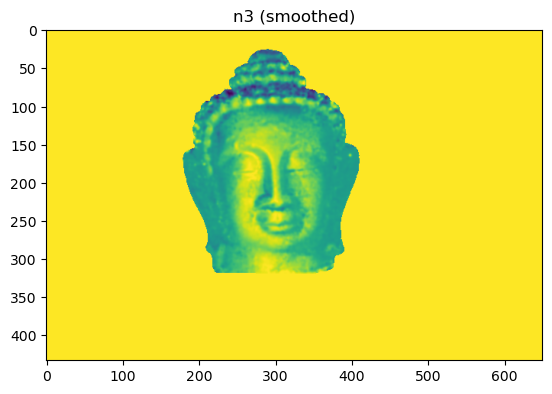

In [20]:

############################## RANSAC version ##############################
normals_image, albedo_image = woodham_ransac(I , Mask, S, threshold=25.0)
n1r, n2r, n3r = extract_surface_normals(normals_image)

# Visualize albedo image
plt.imshow(albedo_image); plt.title("albedo ransac"); plt.show()

#### Raw normals 
plt.imshow(n1r); plt.title("n1 (raw)"); plt.show()
plt.imshow(n2r); plt.title("n2 (raw)"); plt.show()
plt.imshow(n3r); plt.title("n3 (raw)"); plt.show()

# Smooth the normal field
n1rs, n2rs, n3rs = ps.smooth_normal_field(n1r, n2r, n3r, mask= Mask, iters=25) #change iteration number here

###smoothed normals
plt.imshow(n1rs); plt.title("n1 (smoothed)"); plt.show()
plt.imshow(n2rs); plt.title("n2 (smoothed)"); plt.show()
plt.imshow(n3rs); plt.title("n3 (smoothed)"); plt.show()

## Face dataset only RANSAC

In [23]:
# Load data
I, Mask, S = ps.read_data_file('DataAndCodeAssignment3/face.mat')

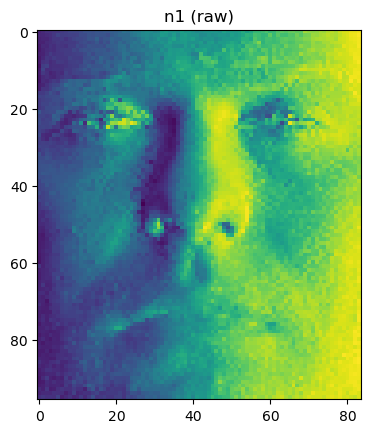

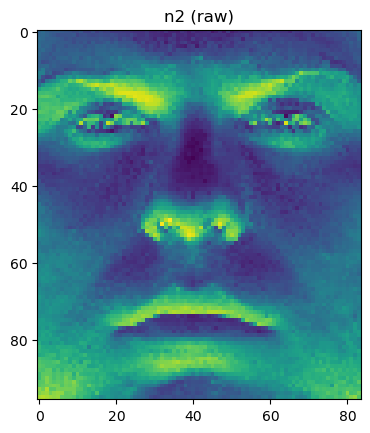

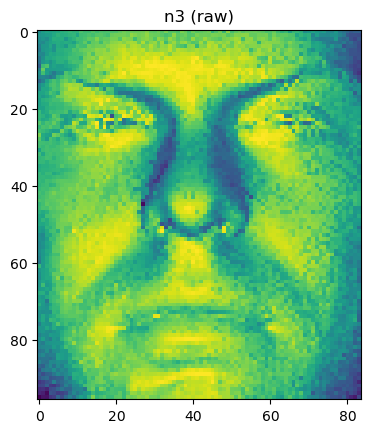

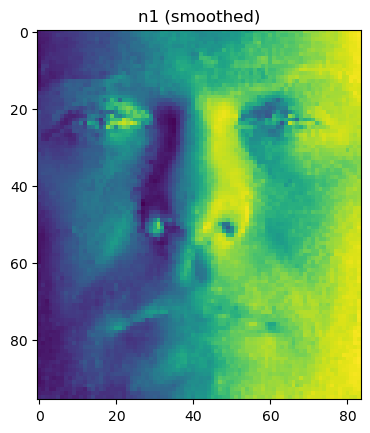

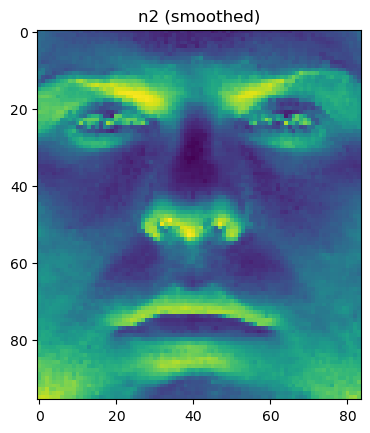

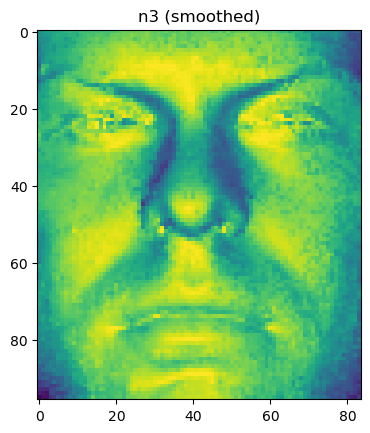

In [24]:

############################## RANSAC version ##############################
normals_image, albedo_image = woodham_ransac(I , Mask, S, threshold=10.0)
n1r, n2r, n3r = extract_surface_normals(normals_image)


#### Raw normals 
plt.imshow(n1r); plt.title("n1 (raw)"); plt.show()
plt.imshow(n2r); plt.title("n2 (raw)"); plt.show()
plt.imshow(n3r); plt.title("n3 (raw)"); plt.show()

# Smooth the normal field
n1rs, n2rs, n3rs = ps.smooth_normal_field(n1r, n2r, n3r, mask= Mask, iters=2) #change iteration number here

###smoothed normals
plt.imshow(n1rs); plt.title("n1 (smoothed)"); plt.show()
plt.imshow(n2rs); plt.title("n2 (smoothed)"); plt.show()
plt.imshow(n3rs); plt.title("n3 (smoothed)"); plt.show()